# Mods

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import joblib

import statsmodels.api as sm

from patsy import dmatrix

from sklearn.preprocessing import LabelEncoder

from sklearn.datasets import load_digits

from scipy.stats import randint

from sklearn.tree import DecisionTreeClassifier

from statsmodels.sandbox.stats.multicomp import multipletests

from sklearn.naive_bayes import MultinomialNB , GaussianNB

from collections import OrderedDict

from sklearn.model_selection import train_test_split ,  RandomizedSearchCV ,  KFold , cross_val_score

from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import confusion_matrix, classification_report , mean_squared_error , make_scorer, recall_score , r2_score , precision_score


# Data Understanding

In [4]:
# Xwines = pd.merge(XWines_Full_21M_ratings, XWines_Full_100K_wines , on= "WineID")
Df = pd.read_csv("/home/r00323024/Xwines/files/Xwines.csv")

In [5]:
pd.set_option('display.max_columns', None)
Df.sample(2)

,RatingID,UserID,WineID,Vintage,Rating,Date,WineName,Type,Elaborate,Grapes,Harmonize,ABV,Body,Acidity,Code,Country,RegionID,RegionName,WineryID,WineryName,Website,Vintages
2258641,2258642,1502350,111452,2009,4.5,2019-02-16 14:57:18,Pauillac (Grand Cru Classé),Red,Varietal/100%,['Petit Verdot'],"['Beef', 'Lamb', 'Game Meat', 'Poultry']",12.5,Full-bodied,High,FR,France,1396,Pauillac,29251,Château Batailley,http://www.batailley.com,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201..."
14102273,14102274,1007595,167456,2016,4.5,2021-05-09 01:24:34,Sapo de Otro Pozo Blend de Tintas,Red,Assemblage/Blend,"['Syrah/Shiraz', 'Cabernet Franc', 'Malbec']","['Beef', 'Pasta', 'Lamb', 'Poultry']",14.0,Full-bodied,High,AR,Argentina,2058,Mendoza,60656,Mosquita Muerta,http://www.mosquitamuertawines.com,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201..."


In [6]:
Df.loc[Df['WineryName'] == "Luis Felipe Edwards"]

,RatingID,UserID,WineID,Vintage,Rating,Date,WineName,Type,Elaborate,Grapes,Harmonize,ABV,Body,Acidity,Code,Country,RegionID,RegionName,WineryID,WineryName,Website,Vintages
3781,3782,1505895,162876,1960,4.0,2015-04-25 00:14:22,Family Selection Gran Reserva Cabernet Sauvignon,Red,Varietal/100%,['Cabernet Sauvignon'],"['Beef', 'Lamb', 'Game Meat', 'Poultry']",14.0,Full-bodied,High,CL,Chile,2267,Central Valley (CL),39110,Luis Felipe Edwards,http://www.lfewines.com,"[2020, 2019, 2018, 2017, 2016, 2015, 2014, 201..."
15954,15955,1207880,162639,1969,5.0,2015-07-04 15:11:05,Dona Bernarda,Red,Assemblage/Blend,"['Carmenère', 'Syrah/Shiraz', 'Cabernet Sauvig...","['Beef', 'Lamb', 'Game Meat', 'Spicy Food', 'M...",14.5,Full-bodied,High,CL,Chile,2267,Central Valley (CL),39110,Luis Felipe Edwards,http://www.lfewines.com,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201..."
21912,21913,1896320,162751,1971,4.0,2014-04-21 20:54:22,Family Selection Gran Reserva Carmenère,Red,Varietal/100%,['Carmenère'],"['Beef', 'Pasta', 'Lamb', 'Poultry']",14.0,Full-bodied,High,CL,Chile,2267,Central Valley (CL),39110,Luis Felipe Edwards,http://www.lfewines.com,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201..."
30503,30504,1336925,163166,1975,5.0,2014-11-30 23:36:22,Family Selection Gran Reserva Sauvignon Blanc,White,Varietal/100%,['Sauvignon Blanc'],"['Shellfish', 'Vegetarian', 'Goat Cheese']",13.5,Medium-bodied,High,CL,Chile,2267,Central Valley (CL),39110,Luis Felipe Edwards,http://www.lfewines.com,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201..."
43102,43103,2050441,163215,1979,4.0,2015-05-28 14:06:31,Merlot,Red,Varietal/100%,['Merlot'],"['Beef', 'Lamb', 'Veal']",13.0,Full-bodied,High,CL,Chile,2267,Central Valley (CL),39110,Luis Felipe Edwards,http://www.lfewines.com,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20565133,20565134,1363457,164832,2021,4.5,2021-07-13 23:57:45,Winemaker's Selection Reserva Viognier,White,Varietal/100%,['Viognier'],"['Pork', 'Rich Fish', 'Spicy Food', 'Poultry']",13.5,Medium-bodied,Low,CL,Chile,2267,Central Valley (CL),39110,Luis Felipe Edwards,http://www.lfewines.com,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201..."
20565374,20565375,1012698,164832,2021,3.0,2021-12-12 16:23:00,Winemaker's Selection Reserva Viognier,White,Varietal/100%,['Viognier'],"['Pork', 'Rich Fish', 'Spicy Food', 'Poultry']",13.5,Medium-bodied,Low,CL,Chile,2267,Central Valley (CL),39110,Luis Felipe Edwards,http://www.lfewines.com,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201..."
20566738,20566739,1241355,165758,2021,3.0,2021-12-27 18:39:22,Favoritos Chardonnay-Viognier,White,Assemblage/Blend,"['Chardonnay', 'Viognier']","['Pork', 'Game Meat', 'Rich Fish', 'Shellfish'...",12.5,Full-bodied,Low,CL,Chile,2267,Central Valley (CL),39110,Luis Felipe Edwards,http://www.lfewines.com,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201..."
20567044,20567045,1272683,165758,2021,3.5,2021-12-06 21:26:43,Favoritos Chardonnay-Viognier,White,Assemblage/Blend,"['Chardonnay', 'Viognier']","['Pork', 'Game Meat', 'Rich Fish', 'Shellfish'...",12.5,Full-bodied,Low,CL,Chile,2267,Central Valley (CL),39110,Luis Felipe Edwards,http://www.lfewines.com,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201..."


Text(0.5, 1.0, 'Histogram of Vintage')

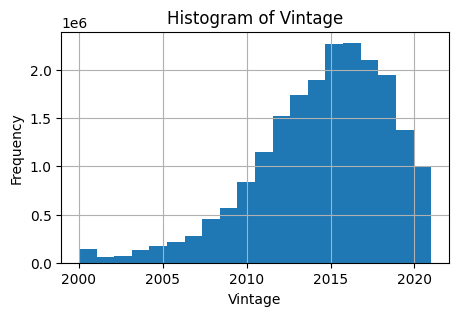

In [7]:
Df1 = Df[Df["Vintage"] != "N.V."]
Df1["Vintage"] = pd.to_numeric(Df1["Vintage"])
Df1 = Df1[Df1['Vintage'] >= 2000]

plt.figure(figsize=(5, 3))  
Df1['Vintage'].hist(bins=20)
plt.xlabel('Vintage')  
plt.ylabel('Frequency') 
plt.title('Histogram of Vintage')  

# Data clean

In [8]:
df = Df.copy()

In [9]:
# 去除重複評分
df = df[df["Vintage"] != "N.V."]

df["Vintage"] = pd.to_numeric(df["Vintage"])

df["Vintage"] = df["Vintage"].astype(str)

df['Date'] = pd.to_datetime(df['Date'])

df['min_date'] = df.groupby(['Vintage', 'UserID', 'WineName'])['Date'].transform('max')

df = df[df['Date'] == df['min_date']]

df = df.drop_duplicates(subset=['Vintage', 'UserID', 'WineName'])

# 只用紅酒
Type = ['Red']
df = df[df['Type'].isin(Type)]

# 創建WineryName-Vintage Level
labels = df['WineryName'] + ' ' + df['Vintage']
df["Label"] = labels

Label_counts = df.groupby("Label").size()

df['amount'] = df['Label'].map(Label_counts)

In [33]:
df1 = df.copy()

In [34]:
# encode 類別變數
label_encoder = LabelEncoder()

df1['Elaborate'] = label_encoder.fit_transform(df1['Elaborate'])
df1['Grapes'] = label_encoder.fit_transform(df1['Grapes'])
df1['Body'] = label_encoder.fit_transform(df1['Body'])
df1['Harmonize'] = label_encoder.fit_transform(df1['Harmonize'])
df1['Acidity'] = label_encoder.fit_transform(df1['Acidity'])
df1['Label'] = label_encoder.fit_transform(df1['Label'])

# Naive Bayes

In [12]:
# 將rating分成好壞
max_rating = df1['Rating'].max()

df1['Rating'] = (df1['Rating'] / max_rating) * 10

def map_rating(x):
    if x <= 6:
        return 0
    else:
        return 1 

df1['MapRating'] = df1['Rating'].apply(map_rating)

In [13]:
y = df1['MapRating'] 
X = df1[['Elaborate','Grapes','Harmonize','ABV','Body','Acidity']]

In [14]:
NB = MultinomialNB(alpha=1.0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,random_state=1)

NB.fit(X_train, y_train)

MultinomialNB()

In [15]:
joblib.dump(NB, '/home/r00323024/Xwines/files/NB.joblib')
# NB = joblib.load('/home/r00323024/Xwines/files/NB.joblib')

['/home/r00323024/Xwines/files/NB.joblib']

              precision    recall  f1-score   support

           0       0.20      0.46      0.28    546671
           1       0.83      0.60      0.69   2440845

    accuracy                           0.57   2987516
   macro avg       0.52      0.53      0.49   2987516
weighted avg       0.72      0.57      0.62   2987516



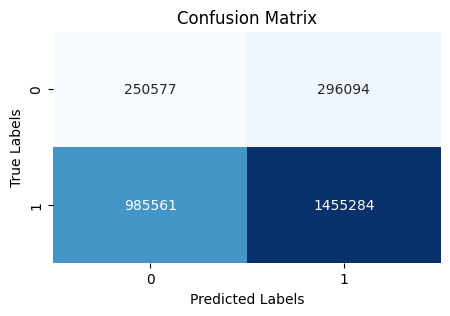

In [16]:
y_pred = NB.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')


report = classification_report(y_test, y_pred)
print(report)

# Tree

In [35]:
# 將rating分成好壞
max_rating = df1['Rating'].max()
df1['Rating'] = (df1['Rating'] / max_rating) * 10
df1 = df1.drop(df1[(df1['Rating'] >= 4) & (df1['Rating'] <= 7)].index)

def map_rating(x):
    if x <= 4:
        return 0
    else:
        return 1 

df1['MapRating'] = df1['Rating'].apply(map_rating)

In [36]:
y = df1[['MapRating']]
X = df1[['Elaborate','Grapes','ABV','Body','Acidity']]

In [37]:
rus = RandomOverSampler(random_state = 1)
X, y = rus.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,random_state=1)

In [38]:

clf = DecisionTreeClassifier(random_state=1)
# 定義參數分佈
param_dist = {
    'max_depth': randint(20, 40),
    'min_samples_split': randint(5, 10),
    'min_samples_leaf': randint(2, 10),
}

# 使用 precision 作為評估指標
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=20, cv=5, scoring='precision')
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)


Best parameters: {'max_depth': 38, 'min_samples_leaf': 2, 'min_samples_split': 5}


              precision    recall  f1-score   support

           0       0.67      0.63      0.65   1980983
           1       0.65      0.69      0.67   1980983

    accuracy                           0.66   3961966
   macro avg       0.66      0.66      0.66   3961966
weighted avg       0.66      0.66      0.66   3961966



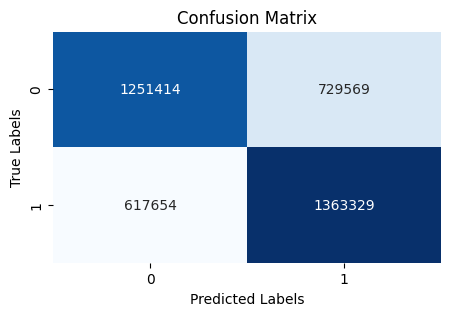

In [39]:

best_clf = random_search.best_estimator_
y_pred = best_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

report = classification_report(y_test, y_pred)
print(report)

In [41]:
joblib.dump(best_clf, '/home/r00323024/Xwines/files/best_clf.joblib')
# best_clf = joblib.load('/home/r00323024/Xwines/files/best_clf.joblib')

['/home/r00323024/Xwines/files/best_clf.joblib']

# OLS

In [23]:
x_values = [250, 500, 750, 1000]

counts = [len(df[df['amount'] > x]) for x in x_values]

result = dict(zip(x_values, counts))

result

{250: 8523222, 500: 6324843, 750: 5047239, 1000: 4219898}

In [42]:
# 避免過多noise
df1 = df[df['amount'] > 500]

In [43]:
columns_to_group = ['WineID',"Label"]
df1 =df1.groupby(columns_to_group)['Rating'].mean().reset_index()

In [44]:
df1.sample(5)

,WineID,Label,Rating
20110,138846,Gaja 2006,4.000000
62917,185257,SIMI 2016,4.000000
63298,187721,Sterling Vineyards 2016,4.000000
9504,117501,Joseph Drouhin 2014,3.727273
48095,168420,Doña Paula 2016,3.546053


In [47]:
%load_ext sql
%sql sqlite://

conn = sqlite3.connect(':memory:')  # Use ':memory:' for in-memory database

df1.to_sql('table1', conn, index=False, if_exists='replace')

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


64189

In [48]:
Label = pd.read_sql_query("SELECT Label FROM table1;", conn)

X = pd.get_dummies(Label , sparse = True).astype(int)

new_cols = [col.removeprefix('Label_') for col in X.columns]
X.columns = new_cols
X = sm.add_constant(X)  

X

const  1000 Stories 2014  1000 Stories 2015  1000 Stories 2016  \
0        1.0                  0                  0                  0   
1        1.0                  0                  0                  0   
2        1.0                  0                  0                  0   
3        1.0                  0                  0                  0   
4        1.0                  0                  0                  0   
...      ...                ...                ...                ...   
64184    1.0                  0                  0                  0   
64185    1.0                  0                  0                  0   
64186    1.0                  0                  0                  0   
64187    1.0                  0                  0                  0   
64188    1.0                  0                  0                  0   

       1000 Stories 2017  1000 Stories 2018  14 Hands 2011  14 Hands 2012  \
0                      0                  0              0              0   
1                      0                  0              0              0   
2                      0                  0              0              0   
3                      0                  0              0              0   
4                      0                  0              0              0   
...                  ...                ...            ...            ...   
64184                  0                  0              0              0   
64185                  0                  0              0              0   
64186                  0                  0              0              0   
64187                  0                  0              0              0   
64188                  0                  0              0              0   

       14 Hands 2013  14 Hands 2014  14 Hands 2015  14 Hands 2016  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
64184              0              0              0              0   
64185              0              0              0              0   
64186              0              0              0              0   
64187              0              0              0              0   
64188              0              0              0              0   

       19 Crimes 2011  19 Crimes 2012  19 Crimes 2013  19 Crimes 2014  \
0                   0               0               0               0   
1                   0               0               0               0   
2                   0               0               0               0   
3                   0               0               0               0   
4                   0               0               0               0   
...               ...             ...             ...             ...   
64184               0               0               0               0   
64185               0               0               0               0   
64186               0               0               0               0   
64187               0               0               0               0   
64188               0               0               0               0   

       19 Crimes 2015  19 Crimes 2016  19 Crimes 2017  19 Crimes 2018  \
0                   0               0               0               0   
1                   0               0               0               0   
2                   0               0               0               0   
3                   0               0               0               0   
4                   0               0               0               0   
...               ...             ...             ...        

In [49]:
Rating = pd.read_sql_query("SELECT Rating FROM table1;", conn)
y = Rating

In [ ]:
model = sm.OLS(y, X)
results = model.fit()

rsquared = results.rsquared
print("R-squared:", rsquared)

In [ ]:
coefficients = results.params
std_errs = results.bse
t_values = results.tvalues
p_values = results.pvalues
conf_ints = results.conf_int()

# Creating a DataFrame to store the results
result_df = pd.DataFrame({
    'Coefficient': coefficients,
    'Std Error': std_errs,
    't-value': t_values,
    'P-value': p_values,
    'Confidence Interval (0.025)': conf_ints[0],
    'Confidence Interval (0.975)': conf_ints[1]
})


result_df = result_df.round(10)

result_df

,Coefficient,Std Error,t-value,P-value,Confidence Interval (0.025),Confidence Interval (0.975)
const,3.881915,0.002270,1709.724304,0.000000,3.877465,3.886365
1000 Stories 2014,0.409561,0.234168,1.749009,0.080295,-0.049408,0.868531
1000 Stories 2015,0.207645,0.202798,1.023897,0.305888,-0.189841,0.605130
1000 Stories 2016,0.137029,0.202798,0.675692,0.499239,-0.260456,0.534515
1000 Stories 2017,0.113342,0.202798,0.558892,0.576238,-0.284143,0.510828
...,...,...,...,...,...,...
Álvaro Palacios 2015,0.456342,0.135209,3.375074,0.000738,0.191331,0.721353
Álvaro Palacios 2016,0.496181,0.135209,3.669719,0.000243,0.231170,0.761192
Álvaro Palacios 2017,0.592790,0.143409,4.133561,0.000036,0.311708,0.873873
Álvaro Palacios 2018,0.638956,0.143409,4.455478,0.000008,0.357874,0.920038


In [ ]:
# 設定推薦清單數目
num_tests = 30

def bonferroni (pval, num_tests):

    alpha_0001 = 0.0001 / num_tests
    alpha_001 = 0.001 / num_tests
    alpha_01 = 0.01 / num_tests
    alpha_05 = 0.05 / num_tests

    if pval < alpha_0001:
        return '****'
    elif pval < alpha_001:
        return '***'
    elif pval < alpha_01:
        return '**'
    elif pval < alpha_05:
        return '*'
    else:
        return ''

result_df['P-value'] = result_df['P-value'].astype(float).apply(lambda x: f"{x:.8f}" + bonferroni(x, num_tests))


In [ ]:
file_path = "/home/r00323024/Xwines/files/OLS.txt"
with open(file_path, "w") as f:
     f.write(result_df.to_string())

In [ ]:
# 儲存推薦清單
Toplist = result_df.copy()

cols = ['Std Error','Confidence Interval (0.025)','Confidence Interval (0.975)']
Toplist.drop(cols, axis=1, inplace=True)

Toplist = Toplist[(Toplist['Coefficient'] > 0.8) & (Toplist['P-value'].str.contains(r'\*'))]

file_path = "/home/r00323024/Xwines/files/Recommendation.txt"
with open(file_path, "w") as f:
     f.write(Toplist.to_string())